In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
epoch_key = ('HPa', 6, 2)

In [4]:
from loren_frank_data_processing import get_interpolated_position_dataframe
from src.parameters import ANIMALS

In [5]:
from spectral_connectivity import Multitaper, Connectivity
from loren_frank_data_processing import get_LFP_dataframe, reshape_to_segments, make_tetrode_dataframe

tetrode_info = make_tetrode_dataframe(ANIMALS).xs(
        epoch_key, drop_level=False)

is_brain_areas = tetrode_info.area.isin(['CA1'])
is_brain_areas = is_brain_areas & tetrode_info.descrip.isin(['riptet'])
tetrode_keys = tetrode_info[is_brain_areas].index.tolist()

LFPs = [get_LFP_dataframe(tetrode_key, ANIMALS)
        for tetrode_key in tetrode_keys]

tetrode_info[is_brain_areas].loc[:, ['area', 'depth', 'descrip']]

area    depth descrip
animal day epoch tetrode_number                      
HPa    6   2     1               CA1  [[114]]  riptet
                 4               CA1  [[117]]  riptet
                 5               CA1  [[117]]  riptet
                 6               CA1  [[110]]  riptet
                 7               CA1  [[114]]  riptet

In [6]:
from ripple_detection import Kay_ripple_detector

hippocampus_lfps = pd.concat(
    [get_LFP_dataframe(tetrode_key, ANIMALS)
     for tetrode_key in tetrode_keys], axis=1, keys=tetrode_keys).astype(float).resample('1ms').mean().dropna()
time = hippocampus_lfps.index

def _time_function(epoch_key, animals):
    return time

speed = get_interpolated_position_dataframe(
    epoch_key, ANIMALS, _time_function).speed

sampling_frequency = 1000

ripple_times = Kay_ripple_detector(
        time, hippocampus_lfps.values, speed.values, sampling_frequency,
        minimum_duration=pd.Timedelta(milliseconds=15), zscore_threshold=2)

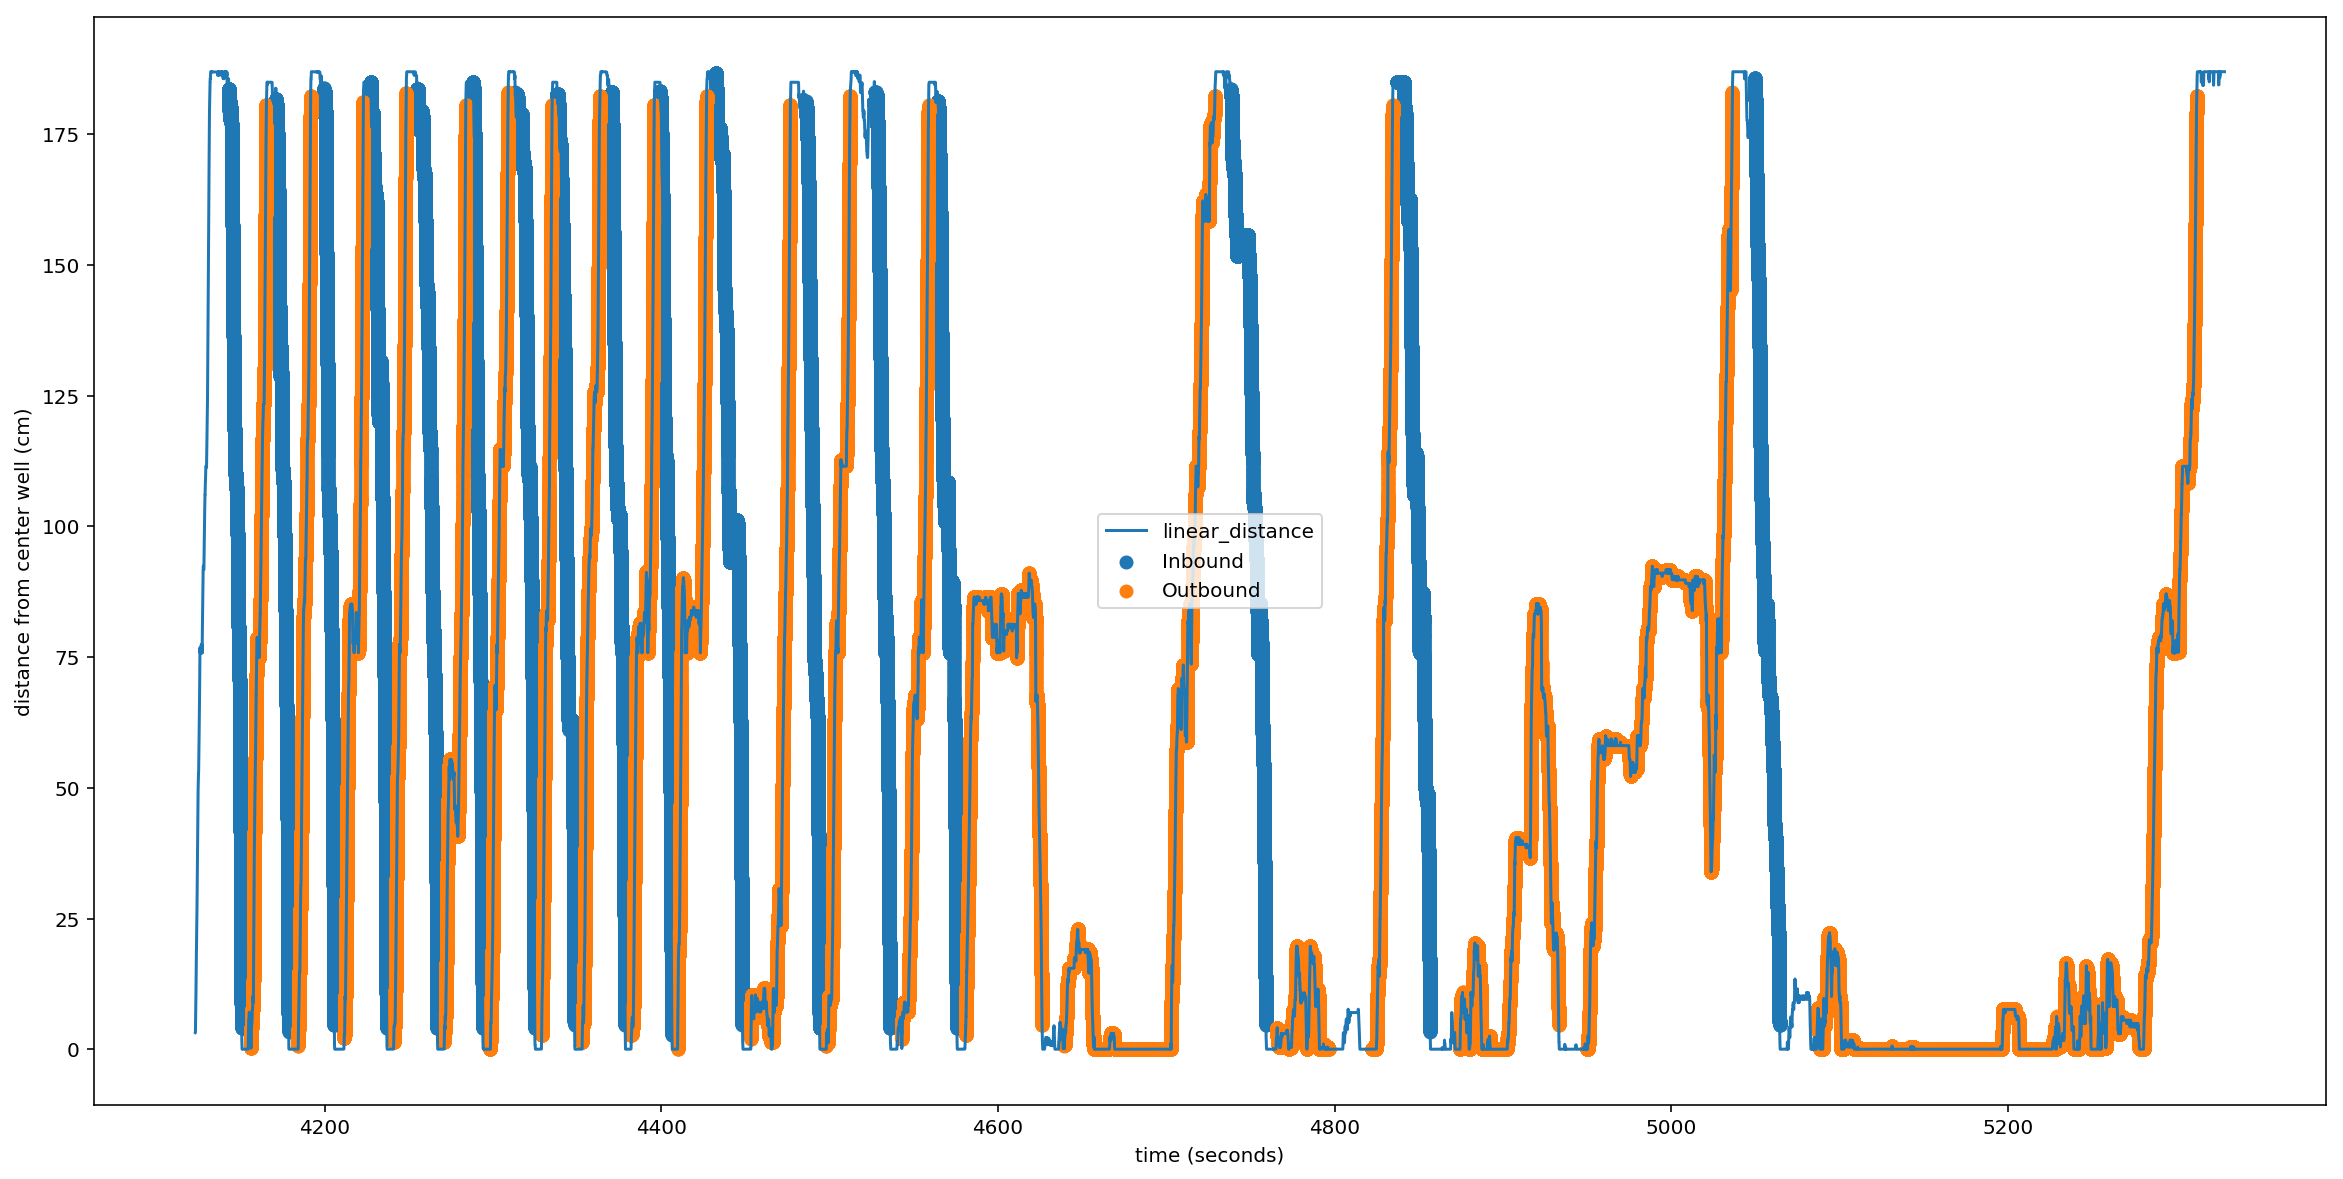

In [7]:
position_info = get_interpolated_position_dataframe(
    epoch_key, ANIMALS, time_function=_time_function, max_distance_from_well=5)

plt.figure(figsize=(20, 10))
plt.plot(position_info.index.total_seconds(), position_info.linear_distance)

for label, df in position_info.groupby('task'):
    plt.scatter(df.index.total_seconds(), df.linear_distance, label=label)

plt.xlabel('time (seconds)')
plt.ylabel('distance from center well (cm)')
plt.legend();

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=3,
           time_window_duration=0.1, time_window_step=0.1,
           detrend_type='constant', start_time=-0.5, n_tapers=5)


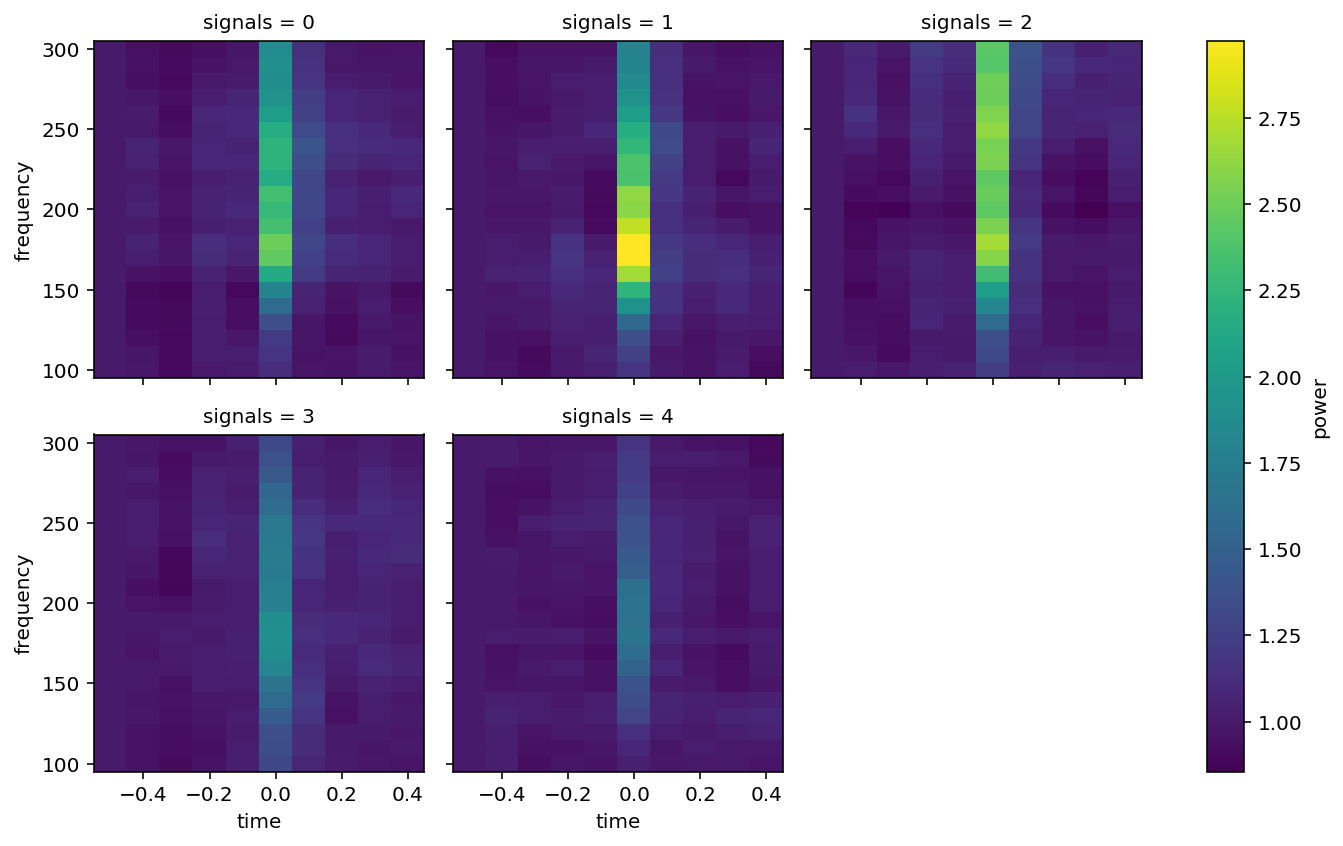

In [8]:
window_offset = (-0.5, 0.5)

ripple_locked_LFPs = reshape_to_segments(hippocampus_lfps, ripple_times, window_offset=window_offset)
data = (ripple_locked_LFPs.to_panel().to_xarray().transpose('minor_axis', 'major_axis', 'items').values)
ripple_time = ripple_locked_LFPs.unstack(level=0).index.get_level_values('time').total_seconds().values
m = Multitaper(data, sampling_frequency, time_window_duration=0.100,
               time_halfbandwidth_product=3, start_time=ripple_time[0])
c = Connectivity.from_multitaper(m)
power = xr.DataArray(c.power(), dims=('time', 'frequency', 'signals'), coords=dict(time=c.time, frequency=c.frequencies), name='power')
(power / power.isel(time=0)).sel(frequency=slice(100, 300)).plot(x='time', y='frequency', col='signals', col_wrap=3);

In [9]:
m = Multitaper(hippocampus_lfps.values, sampling_frequency, time_window_duration=0.020,
               time_halfbandwidth_product=1, start_time=time.total_seconds()[0])
c = Connectivity.from_multitaper(m)
ripple_power = xr.DataArray(c.power(), dims=('time', 'frequency', 'signals'),
                            coords=dict(time=pd.TimedeltaIndex(c.time, unit='s'), frequency=c.frequencies), name='power')
ripple_power = ripple_power.sel(frequency=200).reindex(time)
ripple_power /= ripple_power.mean('time')
ripple_locked_power = reshape_to_segments(ripple_power.drop('frequency').to_dataframe().unstack(), ripple_times, window_offset)

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.02,
           detrend_type='constant', start_time=4122.992, n_tapers=1)


In [10]:
ripple_duration = ripple_times.end_time.dt.total_seconds() - ripple_times.start_time.dt.total_seconds()

In [11]:
from ripple_detection.core import filter_ripple_band

ripple_filtered_LFPs = pd.DataFrame(
    np.stack([filter_ripple_band(lfp, sampling_frequency) for lfp in hippocampus_lfps.values.T], axis=1),
    index=time, columns=tetrode_keys)

ripple_locked_filtered_LFPs = reshape_to_segments(ripple_filtered_LFPs, ripple_times, window_offset=window_offset)

In [12]:
from ipywidgets import interact

def plot_lfp(ripple_number=1):
    n_LFPs = hippocampus_lfps.shape[1]
    fig, axes = plt.subplots(n_LFPs, 3, figsize=(20, 10), sharex=True)
    for ax, lfp in zip(
            axes[:, 0], ripple_locked_LFPs.loc[ripple_number].values.T):
        ax.plot(ripple_time, lfp)
        ax.axvspan(0, ripple_duration.loc[ripple_number], alpha=0.2)
        ax.axhline(0, color='black', linestyle='--')

    for ax, lfp in zip(
            axes[:, 1], ripple_locked_filtered_LFPs.loc[ripple_number].values.T):
        ax.plot(ripple_time, lfp, color='orange')
        ax.axvspan(0, ripple_duration.loc[ripple_number], alpha=0.2)
        ax.axhline(0, color='black', linestyle='--')

    power_time = ripple_locked_power.loc[ripple_number].index.total_seconds().values
    for ax, p in zip(axes[:, 2], ripple_locked_power.loc[ripple_number].values.T):
        ax.plot(power_time, p, color='purple')
        ax.axvspan(0, ripple_duration.loc[ripple_number], alpha=0.2)
        ax.axhline(1, color='black', linestyle='--')

    axes[0, 0].set_title('LFP')
    axes[0, 1].set_title('Bandpass Filtered LFP (150 - 250 Hz)')
    axes[0, 2].set_title('Ripple Power Change');

n_ripples = len(ripple_times)
interact(plot_lfp, ripple_number=(1, n_ripples), continuous_update=False);

interactive(children=(IntSlider(value=1, description='ripple_number', max=217, min=1), Output()), _dom_classes=('widget-interact',))

In [7]:
from loren_frank_data_processing import make_neuron_dataframe, get_spike_indicator_dataframe

neuron_info = make_neuron_dataframe(ANIMALS).xs(epoch_key, drop_level=False).loc[:, ['area']].dropna()

In [14]:
spikes_data = pd.concat([get_spike_indicator_dataframe(neuron_key, ANIMALS, time_function=_time_function)
               for neuron_key in neuron_info.index], axis=1)
ripple_locked_spikes = reshape_to_segments(spikes_data, ripple_times, window_offset)

In [15]:
def plot_neurons_by_ripple(ripple_number):
    ripple_spikes = np.nonzero(ripple_locked_spikes.loc[ripple_number].fillna(0.0).values)
    n_neurons = len(neuron_info)
    fig, ax = plt.subplots()
    ax.scatter(ripple_time[ripple_spikes[0]], ripple_spikes[1], s=10)
    ax.set_yticks(np.arange(n_neurons))
    ax.axvspan(0, ripple_duration.loc[ripple_number], alpha=0.2)
    ax.set_yticklabels(neuron_info.area.values);
    ax.set_xlim(window_offset)

interact(plot_neurons_by_ripple, ripple_number=(1, n_ripples));

interactive(children=(IntSlider(value=109, description='ripple_number', max=217, min=1), Output()), _dom_classes=('widget-interact',))

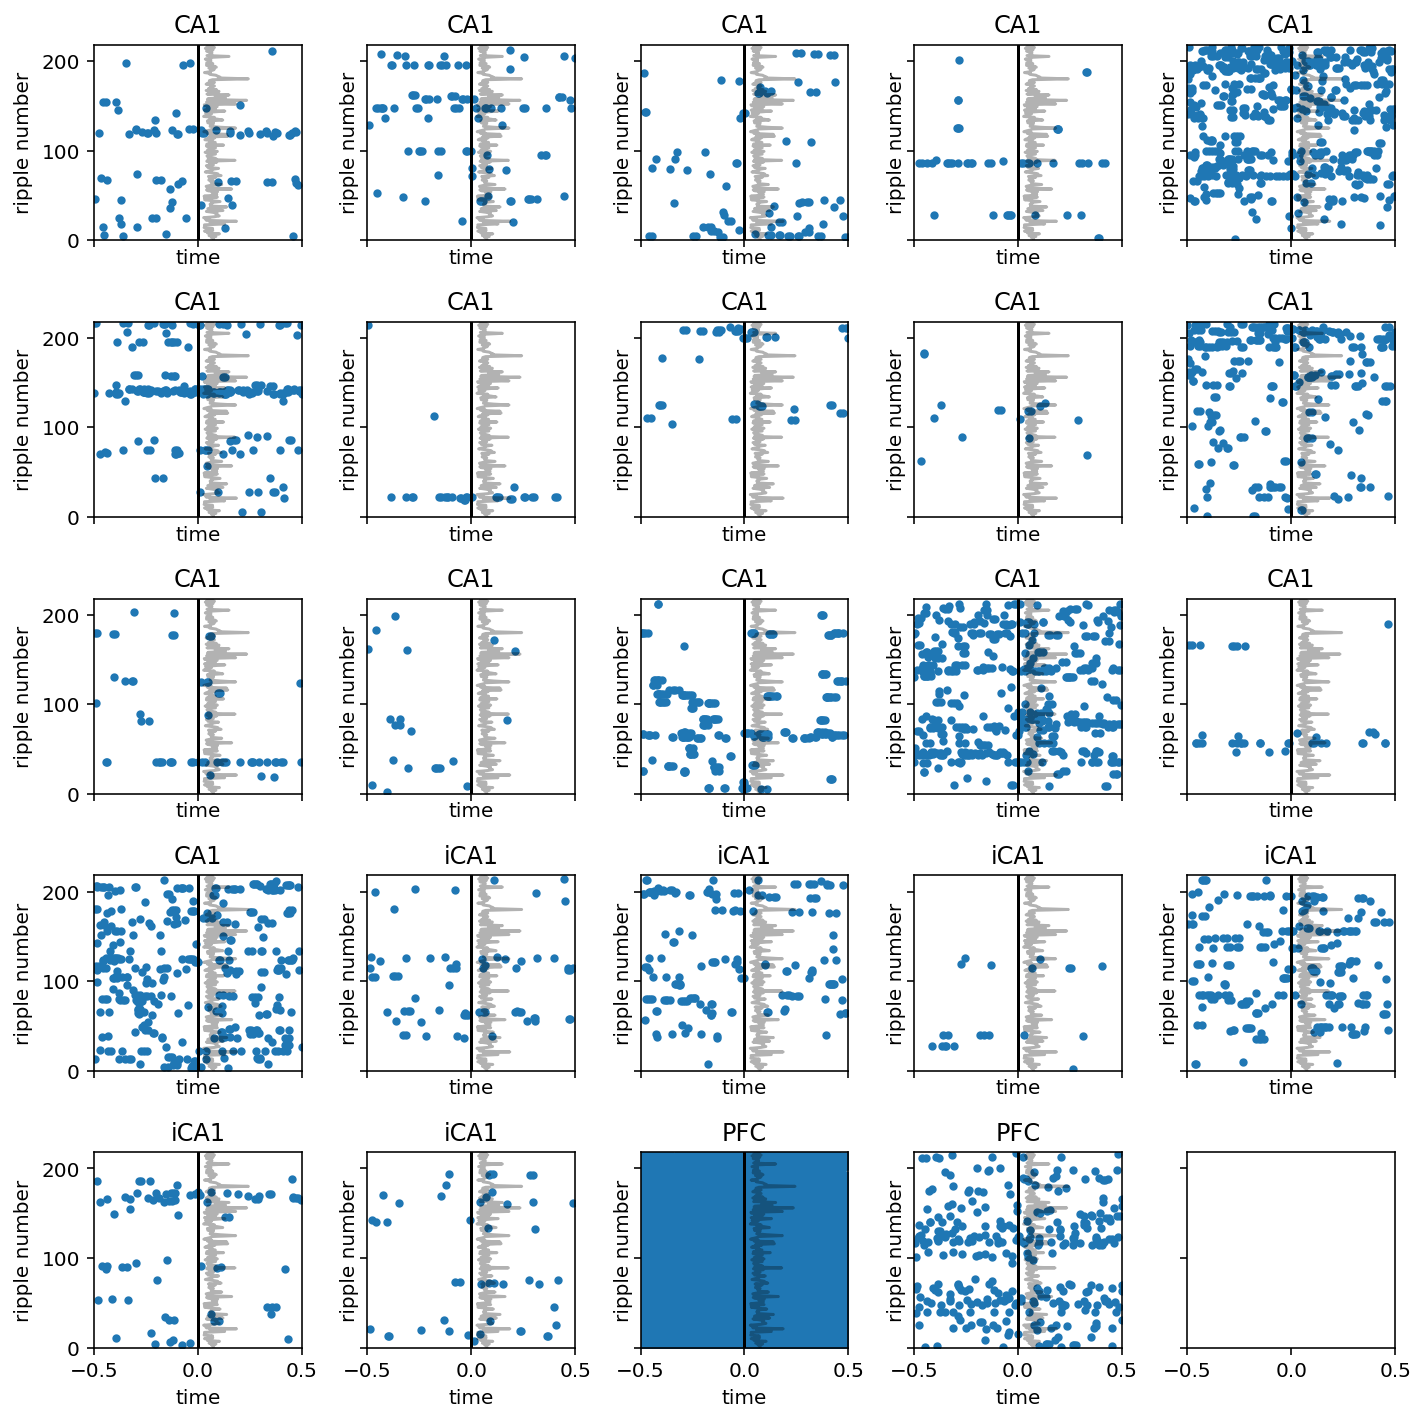

In [16]:

fig, axes = plt.subplots(5, 5, figsize=(10, 10), sharex=True, sharey=True)
for neuron_ind, ax in enumerate(axes.ravel()):
    try:
        df = ripple_locked_spikes.iloc[:, neuron_ind].unstack(level=0).fillna(0.0)
        neuron_ripple_spikes = np.nonzero(df.values)
        t = df.index.total_seconds().values
        ax.scatter(t[neuron_ripple_spikes[0]], neuron_ripple_spikes[1] + 1, s=10)
        ax.plot(ripple_duration.values, ripple_duration.index.values, color='black', alpha=0.3)
        ax.axvline(0.0, color='black')
        ax.set_title(neuron_info.area[neuron_ind])
        ax.set_ylabel('ripple number')
        ax.set_xlabel('time')
        ax.set_ylim((0, n_ripples + 1))
        ax.set_xlim(window_offset)
    except IndexError:
        pass
    
plt.tight_layout()

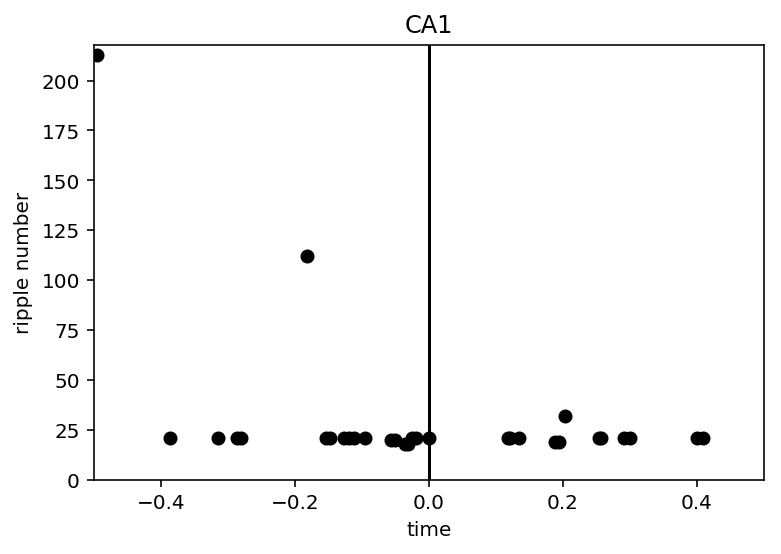

In [14]:
def plot_spikes(neuron_key, animals, ripple_times, neuron_info, window_offset=(-0.5, 0.5), ax=None):
    if ax is None:
        ax = plt.gca()
    spikes = get_spike_indicator_dataframe(neuron_key, ANIMALS)
    ripple_locked_spikes = reshape_to_segments(
        spikes, ripple_times, window_offset=window_offset)
    r = ripple_locked_spikes.unstack(level=0).fillna(0).resample('1ms').sum()
    t = r.index.total_seconds()
    ripple_spike, ripple = np.nonzero(r.values)
    n_ripples = len(ripple_times)

    ax.scatter(t[ripple_spike], ripple, color='black')
    ax.axvline(0.0, color='black')
    ax.set_title(neuron_info.loc[neuron_key].area)
    ax.set_ylabel('ripple number')
    ax.set_xlabel('time')
    ax.set_ylim((0, n_ripples + 1))
    ax.set_xlim(window_offset)
    
plot_spikes(neuron_info.index[6], ANIMALS, ripple_times, neuron_info)

In [18]:
from src.spike_models import summarize_fit, fit_glm, dmatrices, dmatrix, build_design_matrices

def fit_ripple_over_time(neuron_key, animals, ripple_times,
                         penalty=1E-4, window_offset=(-0.100, 0.200), knot_diff=0.050):
    
    spikes = get_spike_indicator_dataframe(neuron_key, animals).resample('1ms').sum()
    ripple_locked_spikes = reshape_to_segments(
        spikes, ripple_times, window_offset=window_offset)
    time = ripple_locked_spikes.index.get_level_values('time')
    trial_id = (ripple_locked_spikes.index
                .get_level_values('ripple_number').values)
    time_knots = window_offset[0] + (np.arange(2 * int(window_offset[1] - window_offset[0] / knot_diff))) * knot_diff
    time_knots = time_knots[1:]
    formula = '1 + cr(time, knots=time_knots, constraints="center")'
    design_matrix = dmatrix(
        formula, dict(time=time.total_seconds().values),
        return_type='dataframe')
    is_spike = ripple_locked_spikes.values.squeeze()

    model_coefficients, AIC, _ = fit_glm(is_spike, design_matrix, penalty)
    unique_time = ripple_locked_spikes.unstack(level=0).index.total_seconds().values
    predict_design_matrix = build_design_matrices(
        [design_matrix.design_info], dict(time=unique_time))[0]

    coords = {'time': unique_time}
    dims = ['time']

    return summarize_fit(
        model_coefficients, predict_design_matrix,
        1000, coords, dims, design_matrix, is_spike,
        trial_id, AIC)

neuron_glm = xr.concat([
    fit_ripple_over_time(neuron_key, ANIMALS, ripple_times, knot_diff=0.1,
                         penalty=0.0001, window_offset=window_offset)
     for neuron_key in neuron_info.index], dim=neuron_info.index)

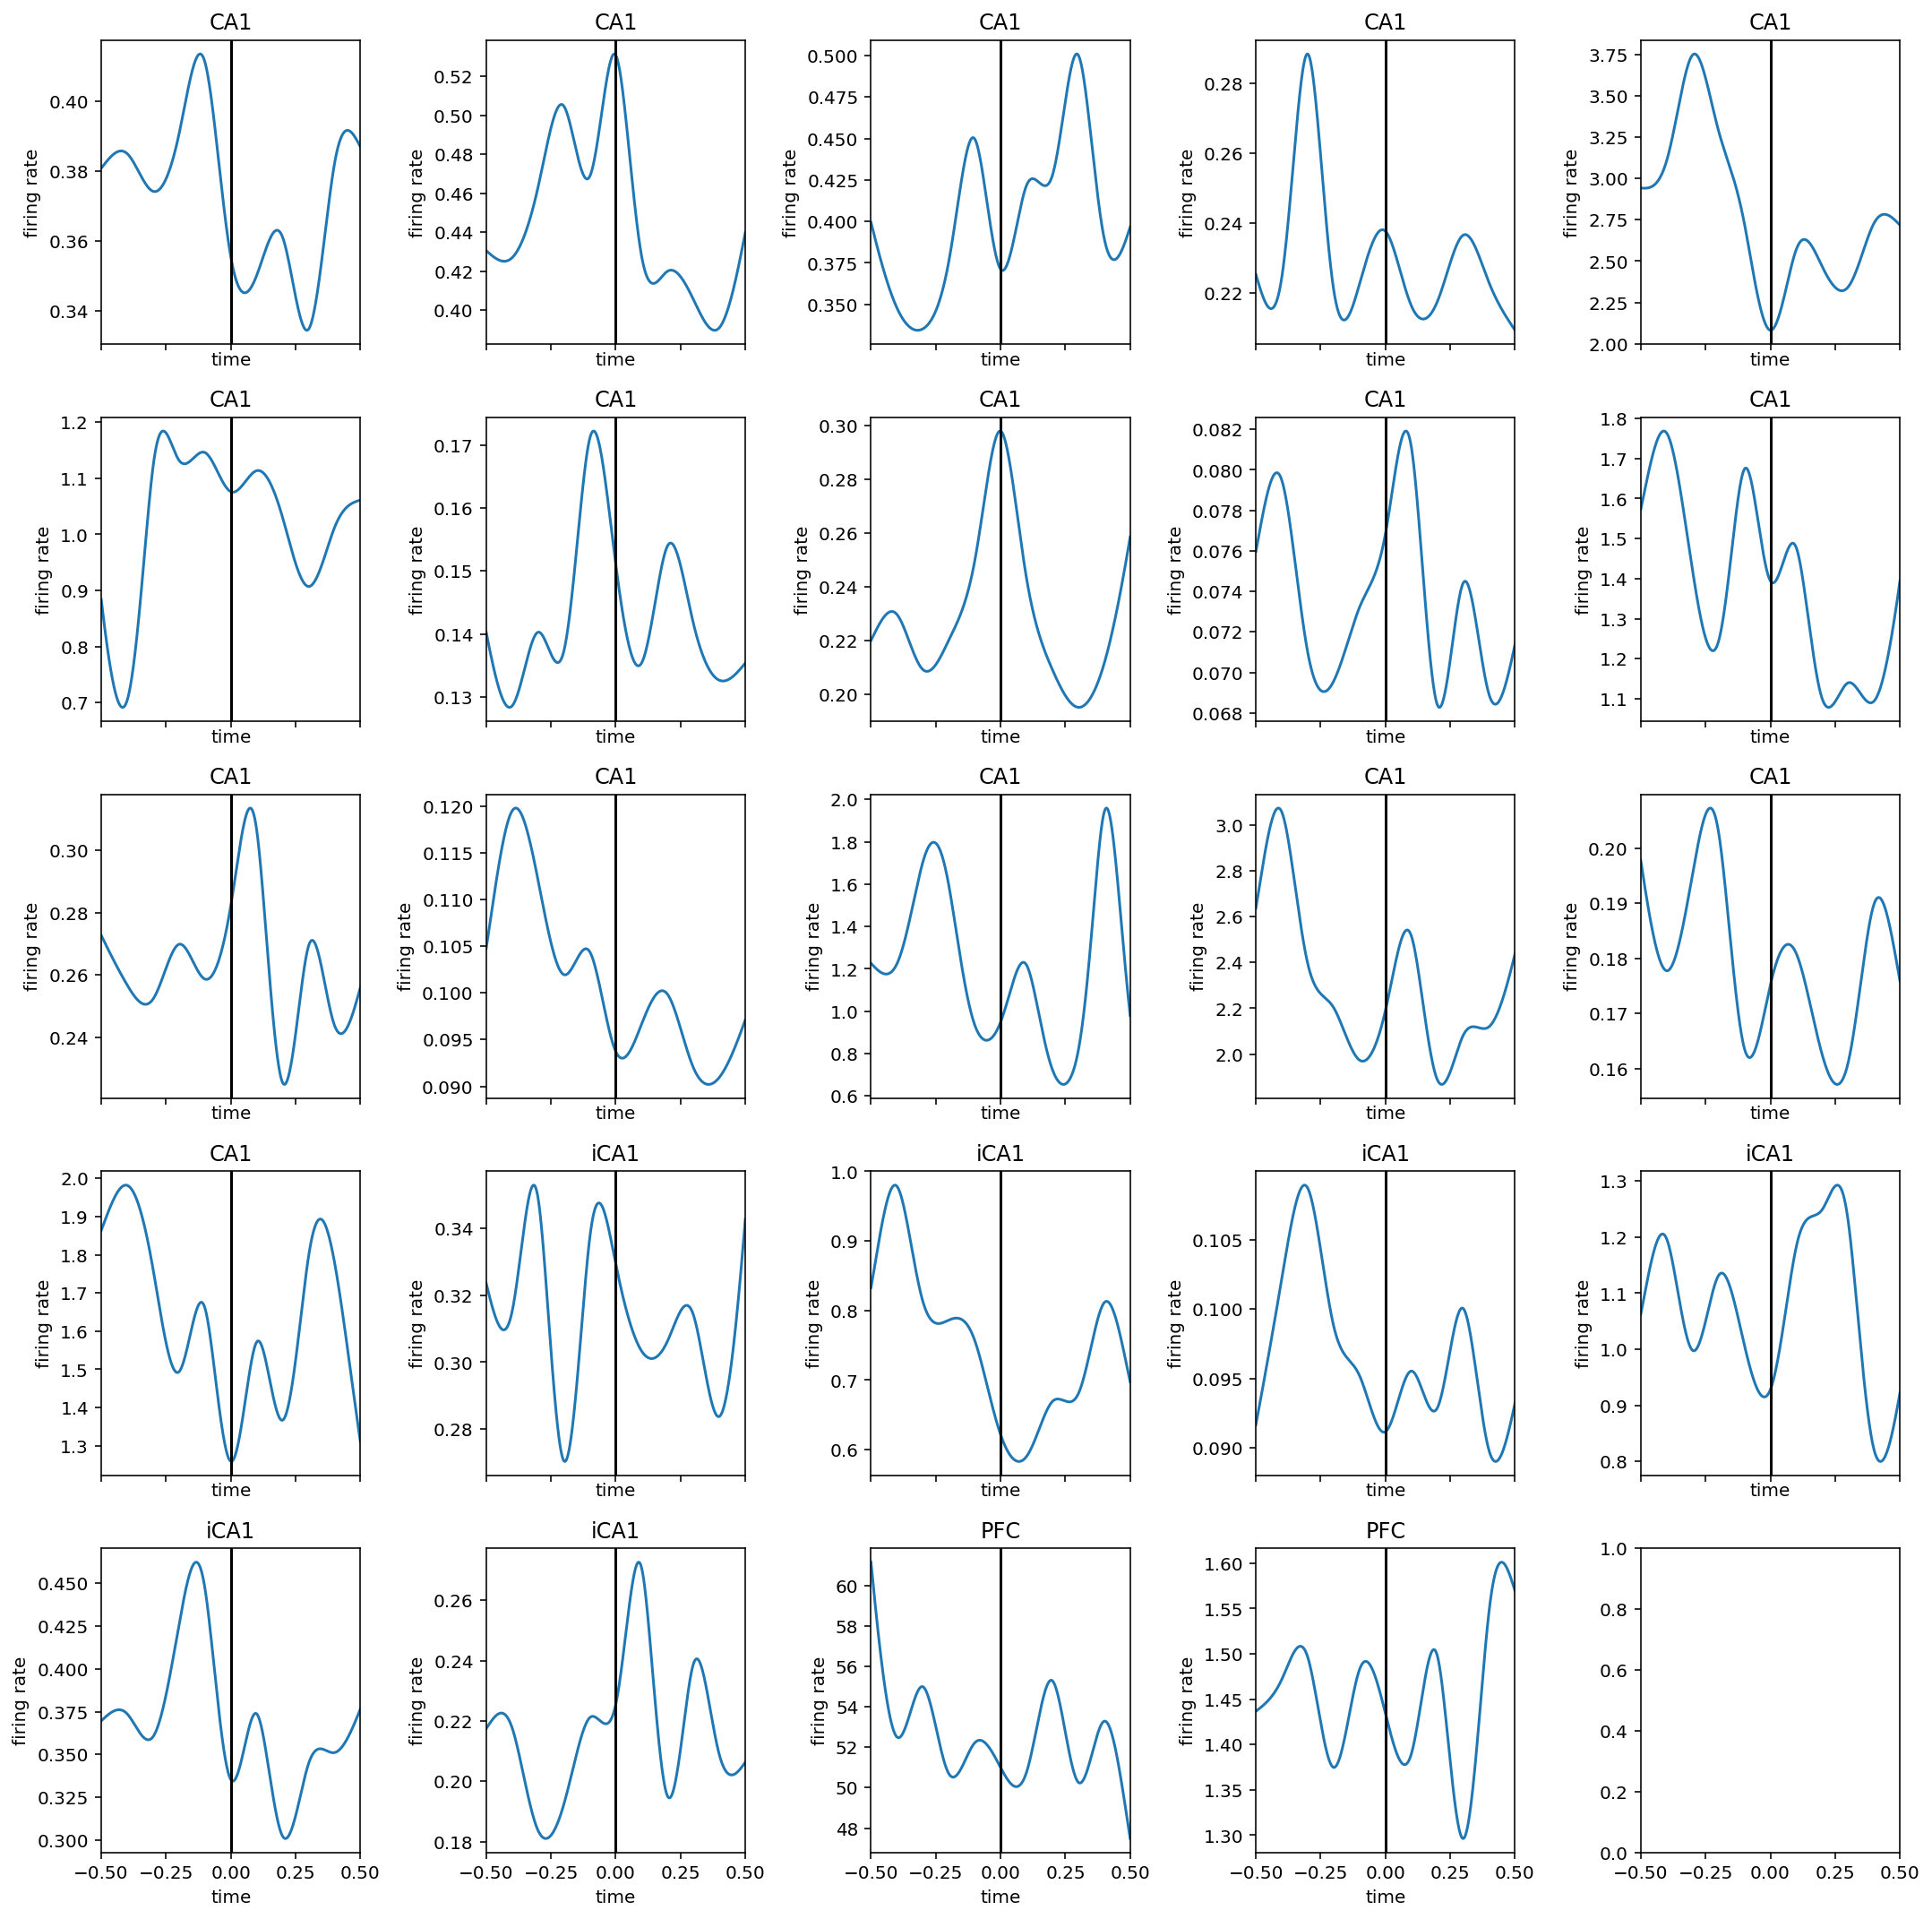

In [29]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15), sharex=True)
for neuron_ind, ax in enumerate(axes.ravel()):
    try:
#         neuron_ripple_spikes = np.nonzero(ripple_locked_spikes.iloc[:, neuron_ind].unstack(level=0).values)
        
        ax.plot(neuron_glm.time, neuron_glm.isel(concat_dim=neuron_ind).firing_rate.values)
#         ax.scatter(ripple_time[neuron_ripple_spikes[0]],
#                    np.zeros_like(neuron_ripple_spikes[0]), s=10, marker='+')
        ax.axvline(0.0, color='black')
        ax.set_title(neuron_info.area[neuron_ind])
        ax.set_ylabel('firing rate')
        ax.set_xlabel('time')
        ax.set_xlim(window_offset)
    except IndexError:
        pass
    
plt.tight_layout()


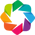

ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPa_direct/EEG/HPaeeg06-2-20.mat
INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


area    depth descrip  numcells animal  day  \
animal day epoch tetrode_number                                                
HPa    6   2     1                CA1  [[114]]  riptet         7    HPa    6   
                 2                CA1  [[121]]     NaN         0    HPa    6   
                 4                CA1  [[117]]  riptet         8    HPa    6   
                 5                CA1  [[117]]  riptet         5    HPa    6   
                 6                CA1  [[110]]  riptet         0    HPa    6   
                 7                CA1  [[114]]  riptet         0    HPa    6   
                 8               iCA1  [[114]]  riptet         1    HPa    6   
                 9               iCA1  [[101]]  riptet         1    HPa    6   
                 10              iCA1   [[98]]     NaN         1    HPa    6   
                 11              iCA1  [[108]]  riptet         1    HPa    6   
                 12              iCA1  [[116]]  riptet         1    HPa    6   
                 13              iCA1  [[120]]     NaN         0    HPa    6   
                 14              iCA1  [[105]]  riptet         1    HPa    6   

                                 epoch  tetrode_number     tetrode_id  
animal day epoch tetrode_number                                        
HPa    6   2     1                   2               1  HPa_06_02_001  
                 2                   2               2  HPa_06_02_002  
                 4                   2               4  HPa_06_02_004  
                 5                   2               5  HPa_06_02_005  
                 6                   2               6  HPa_06_02_006  
                 7                   2               7  HPa_06_02_007  
                 8                   2               8  HPa_06_02_008  
                 9                   2               9  HPa_06_02_009  
                 10                  2              10  HPa_06_02_010  
                 11                  2              11  HPa_06_02_011  
                 12                  2              12  HPa_06_02_012  
                 13                  2              13  HPa_06_02_013  
                 14                  2              14  HPa_06_02_014

In [20]:
from loren_frank_data_processing import (get_interpolated_position_dataframe,
                                         get_LFP_dataframe,
                                         get_multiunit_indicator_dataframe,
                                         get_spike_indicator_dataframe,
                                         make_neuron_dataframe,
                                         make_tetrode_dataframe,
                                         reshape_to_segments, save_xarray)
from replay_classification import ClusterlessDecoder, SortedSpikeDecoder

tetrode_info = make_tetrode_dataframe(ANIMALS).xs(
    epoch_key, drop_level=False)
brain_areas_tetrodes = tetrode_info[
    tetrode_info.area.isin(['CA1',  'iCA1']) &
    ~tetrode_info.descrip.str.endswith('Ref').fillna(False)]

mark_names = get_multiunit_indicator_dataframe(
    brain_areas_tetrodes.index[0], ANIMALS).columns.tolist()
mark_names = [mark_name for mark_name in mark_names
              if mark_name not in ['x_position', 'y_position']]
mark_names = mark_names[:4]
marks = [(get_multiunit_indicator_dataframe(tetrode_key, ANIMALS, time_function=_time_function)
      .loc[:, mark_names])
     for tetrode_key in brain_areas_tetrodes.index]
marks = [tetrode_marks for tetrode_marks in marks
     if (tetrode_marks.loc[position_info.speed > 4, :].dropna()
         .shape[0]) != 0]

train_position_info = position_info.query('speed > 4')

training_marks = np.stack([
    tetrode_marks.loc[train_position_info.index, mark_names]
    for tetrode_marks in marks], axis=0)

n_position_bins = 61
place_std_deviation = 20
mark_std_deviation = 20

decoder = ClusterlessDecoder(
        train_position_info.linear_distance.values,
        train_position_info.task.values,
        training_marks,
        n_position_bins=n_position_bins,
        place_std_deviation=place_std_deviation,
        mark_std_deviation=mark_std_deviation,
        replay_speedup_factor=16,
    ).fit()

display(brain_areas_tetrodes)

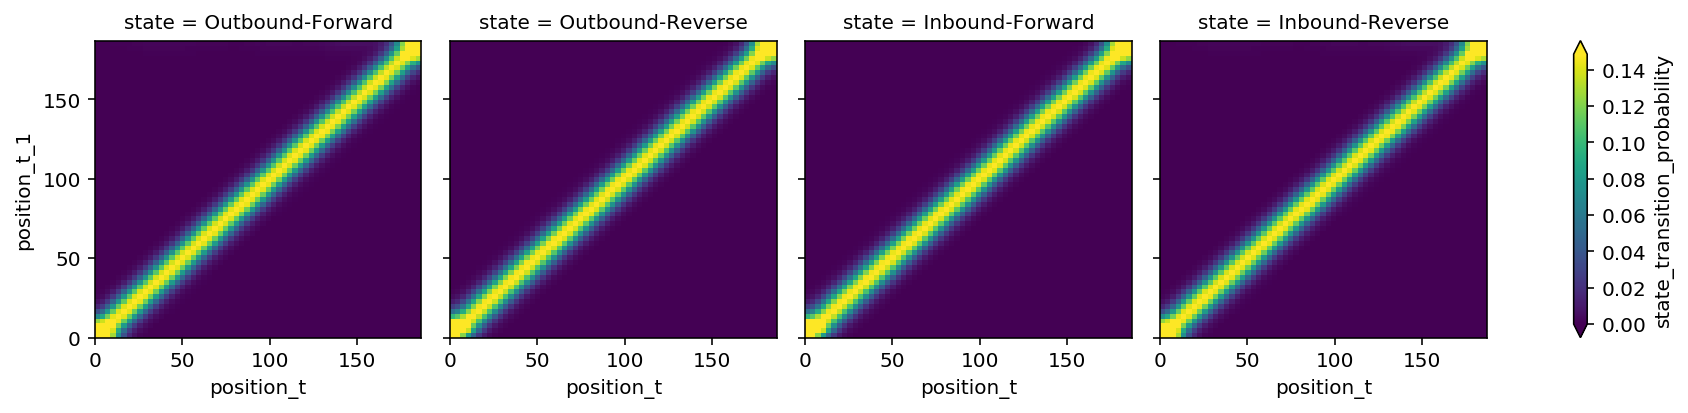

In [21]:
decoder.plot_state_transition_model()

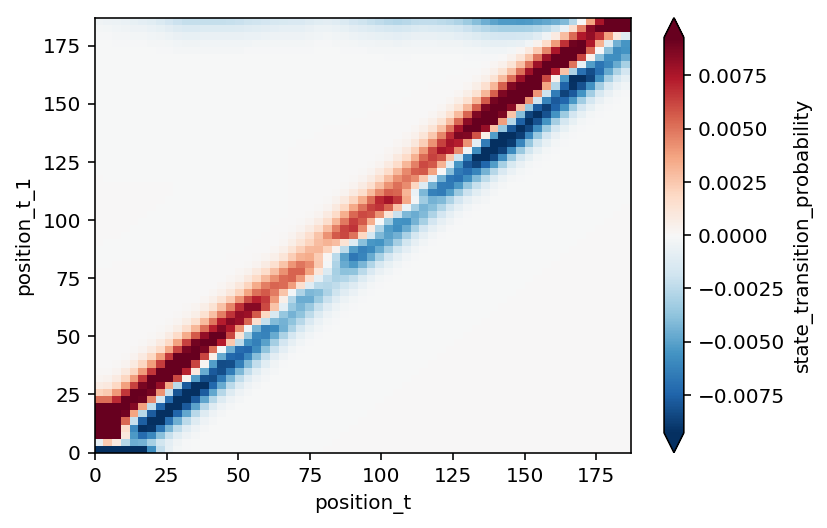

In [22]:
(decoder.state_transition_matrix.sel(state='Inbound-Forward') -
 decoder.state_transition_matrix.sel(state='Outbound-Forward')).plot(x='position_t', y='position_t_1', robust=True)

KeyboardInterrupt: 

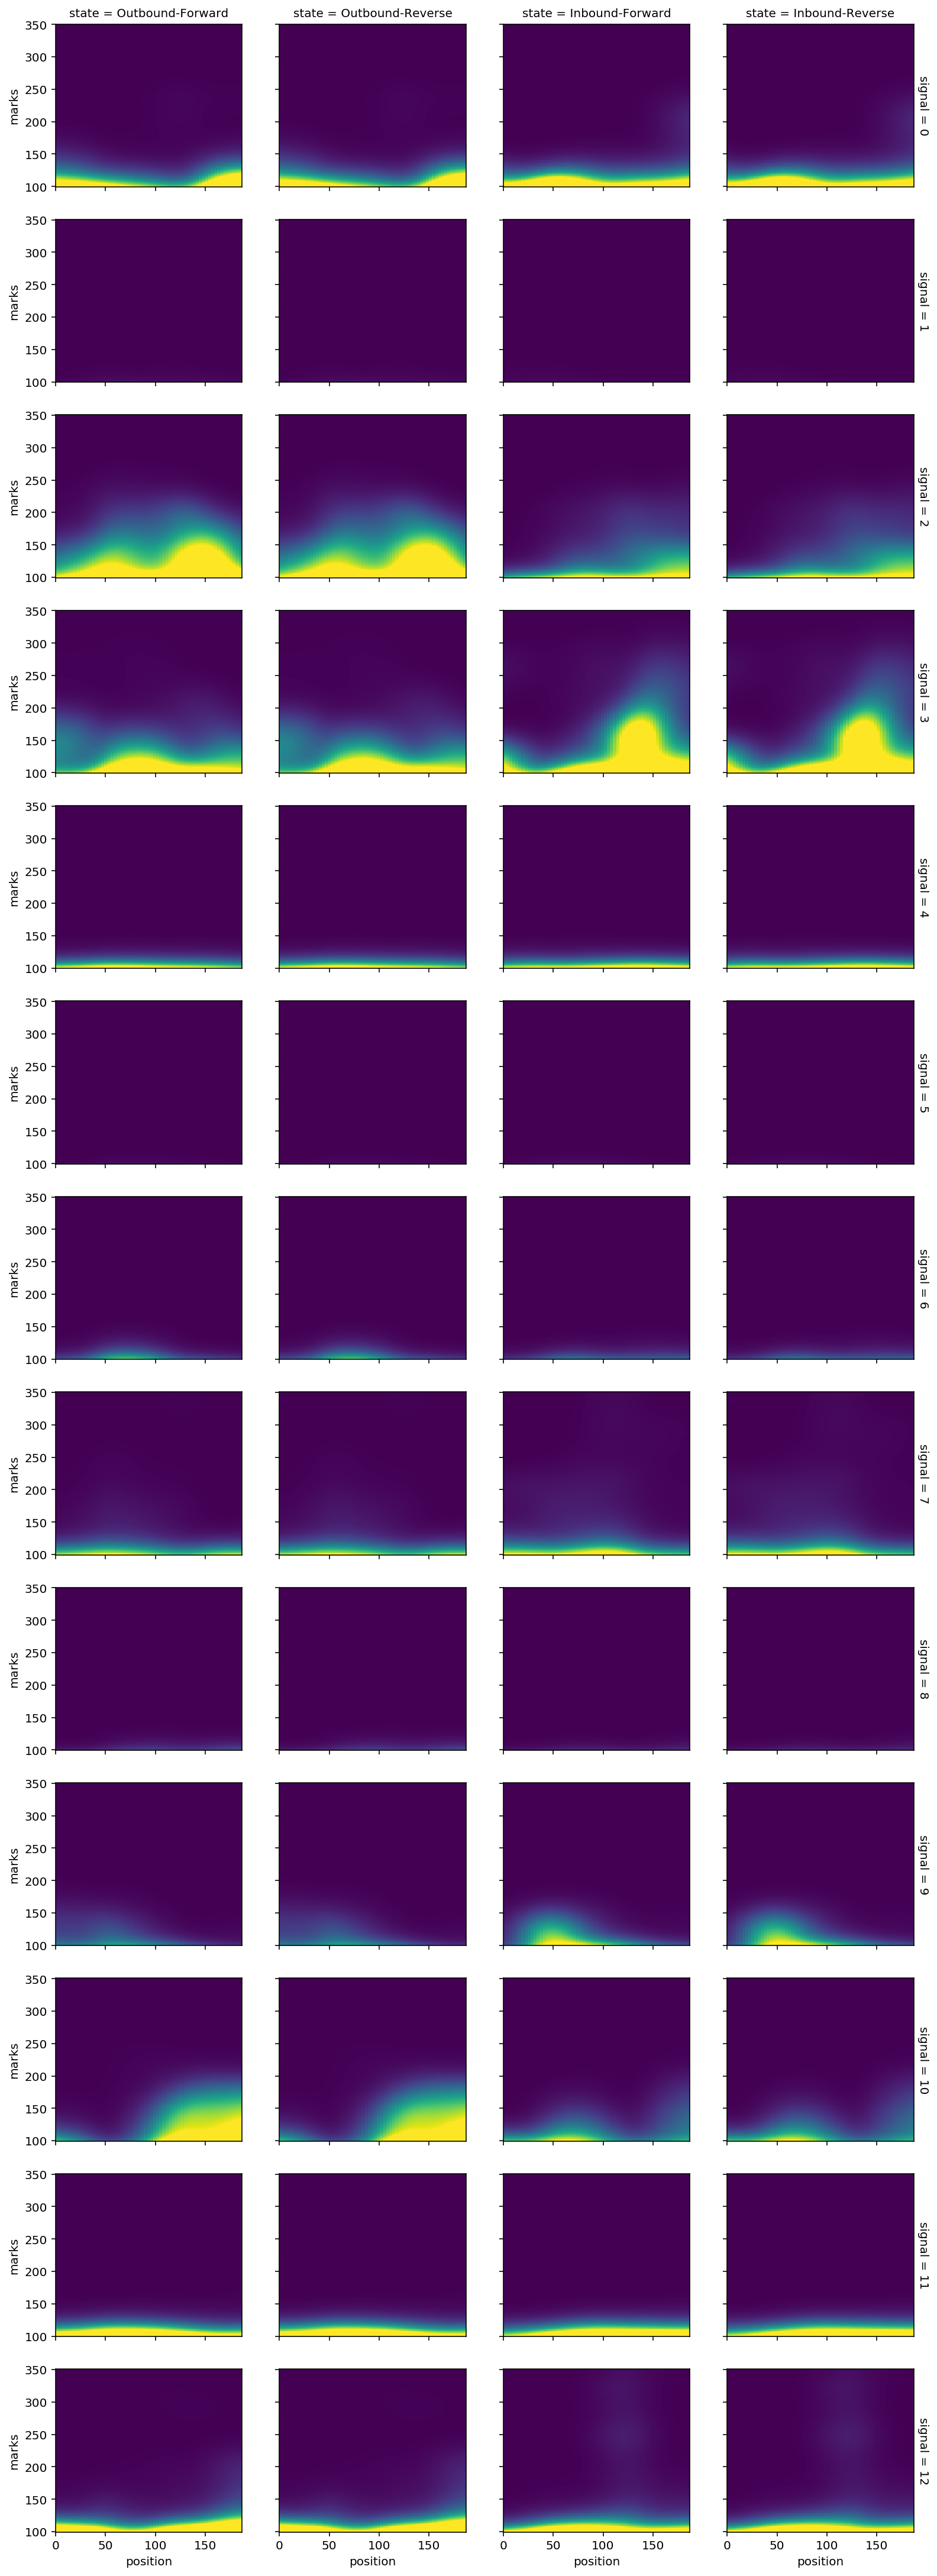

In [23]:
decoder.plot_observation_model()

In [ ]:
from src.analysis import _get_ripple_marks

test_marks = _get_ripple_marks(marks, ripple_times)
results = [decoder.predict(ripple_marks, time.total_seconds())
           for ripple_marks, time in test_marks]

In [ ]:
from src.analysis import summarize_replay_results

(replay_info, decision_state_probability,
            posterior_density) = summarize_replay_results(
        results, ripple_times, position_info, epoch_key)

In [ ]:
replay_info.predicted_state_probability.hist()

In [ ]:
replay_info.predicted_state.hist()

In [ ]:
def plot_posterior(ripple_number):
    g = posterior_density.isel(concat_dim=ripple_number).dropna('time').plot(
        x='time', y='position', col='state', col_wrap=2, robust=True, vmin=0);
    rat_position = replay_info.loc[ripple_number].linear_distance
    for ax in g.axes.ravel():
        ax.axhline(rat_position, color='white', linestyle='--', linewidth=3)
    plt.figure()
    plt.plot(position_info.x_position.values, position_info.y_position.values)
    plt.scatter(replay_info.loc[ripple_number].x_position,
                replay_info.loc[ripple_number].y_position, color='red', zorder=100, s=100)
    plot_lfp(ripple_number)
interact(plot_posterior, ripple_number=(0, len(ripple_times)-1), continuous_update=False);

In [ ]:
results[42].plot_interactive()

In [ ]:
neuron_info = make_neuron_dataframe(ANIMALS).xs(epoch_key, drop_level=False).dropna()
neuron_info = pd.merge(tetrode_info, neuron_info,
                       on=['animal', 'day', 'epoch',
                           'tetrode_number', 'area'],
                       how='right', right_index=True).set_index(
    neuron_info.index)
neuron_info = neuron_info[
    neuron_info.area.isin(['CA1', 'iCA1', 'CA3']) &
    (neuron_info.numspikes > 0) &
    ~neuron_info.descrip.str.endswith('Ref').fillna(False)]
spikes_data = [get_spike_indicator_dataframe(neuron_key, ANIMALS, time_function=_time_function)
               for neuron_key in neuron_info.index]

# Make sure there are spikes in the training data times. Otherwise
# exclude that neuron
spikes_data = [spikes_datum for spikes_datum in spikes_data
               if spikes_datum[
                   position_info.speed > 4].sum() > 0]

train_spikes_data = [spikes_datum[position_info.speed > 4]
                     for spikes_datum in spikes_data]
decoder_sortedspikes = SortedSpikeDecoder(
    position=train_position_info.linear_distance.values,
    spikes=np.stack(train_spikes_data, axis=0),
    trajectory_direction=train_position_info.task.values,
    n_position_bins=n_position_bins,
    replay_speedup_factor=16,
).fit()

display(neuron_info)

In [ ]:
decoder_sortedspikes.plot_observation_model()

In [ ]:
from src.analysis import _get_ripple_spikes

test_spikes = _get_ripple_spikes(
    spikes_data, ripple_times)
results_spikes = [decoder_sortedspikes.predict(ripple_spikes, time.total_seconds())
                  for ripple_spikes, time in test_spikes]

In [ ]:
from src.analysis import summarize_replay_results

(replay_info_sortedspikes, decision_state_probability_sortedspikes,
            posterior_density_sortedspikes) = summarize_replay_results(
        results_spikes, ripple_times, position_info, epoch_key)

In [ ]:
replay_info_sortedspikes.predicted_state_probability.hist()

In [ ]:
replay_info_sortedspikes.predicted_state.hist()

In [ ]:
def plot_posterior_sortedspikes(ripple_number):
    posterior_density_sortedspikes.isel(concat_dim=ripple_number).dropna('time').plot(
        x='time', y='position', col='state', col_wrap=2, robust=True, vmin=0);
interact(plot_posterior_sortedspikes, ripple_number=(0, len(ripple_times)-1), continuous_update=False);

In [ ]:
results_spikes[42].plot_interactive()